# About the Dataset 
Note that the data is already sorted beforehand.

Should you use a different stock prices dataset, *ENSURE* that the data is sorted [in ascending order] by Date as this is crucial in time-series modelling. If this is the case, just uncomment the line in the section below.

Possible (and comprehensive!) sources for your stock prices dataset can also be found in Kaggle: 
1. https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset
2. https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

We use a Google dataset which can be downloaded from Yahoo Finance. The date runs from August 20, 2004 until June 26, 2022. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("hpq.us.txt")
df = df.drop(['Volume', 'OpenInt'], axis=1)
# df = df.sort_values(by=["Date"], ascending=True) <-- uncomment if you need to sort out the data beforehand.

Checking if there are any 0 values (just to be sure).

In [2]:
df.eq(0).any().any()

False

In [3]:
len(df)

12075

In [4]:
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


# Data Visualization

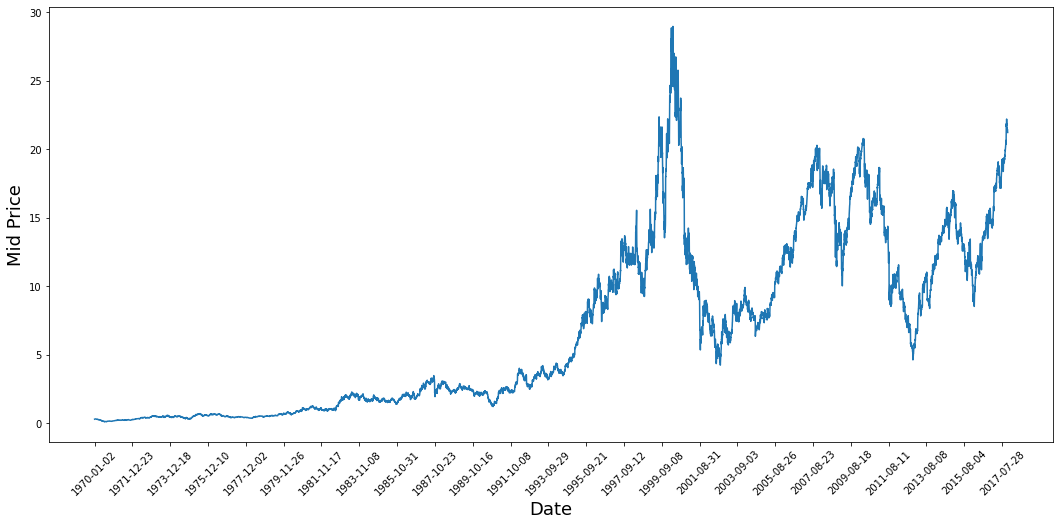

In [5]:
plt.figure(figsize=(18, 8))
plt.plot(range(df.shape[0]), (df['Low'] + df['High']) / 2.0)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

# Handling the data

## Train Test Split

First, we calculate the middle price here since that is what we will use.

In [6]:
high_prices = df.loc[:, 'High'].to_numpy()
low_prices = df.loc[:, 'Low'].to_numpy()

mid_prices = (high_prices + low_prices) / 2.0
print(len(mid_prices))

12075


In [7]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

## Data Normalization

We use **MinMaxScaler** to scale our data for optimal performance. The data will be scaled between (-1, 1).

Remember that both train and test data is normalized according to the train data. You (or the model) should not have access for the test data.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

Going back to our data before, notice that different time periods have different value ranges. So, to normalize this data, we have to split the data into windows. 

The window size we set to 2500. 
Note, however, that this can be changed though remember not to put too small a window size.

In [9]:
smoothing_window_size = 2500

# train the scaler with the training data and smooth data
for di in range(0, 10000, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size, :])

# normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape the data back to [data_size].

In [10]:
train_data = train_data.reshape(-1)

#normalize the test data
test_data = scaler.transform(test_data).reshape(-1)

## Smoothing the data

We smooth data using exponential moving average. It helps to remove inherent "raggedness" of stock price data and to produce a smoother curve.

NOTE: Do not smooth the test data.

In [11]:
EMA = 0.0
gamma = 0.1

for ti in range(len(train_data)):
    EMA = gamma*train_data[ti] + (1 - gamma)*EMA
    train_data[ti] = EMA

all_mid_data = np.concatenate([train_data, test_data], axis=0)

# Averaging Mechanisms

Averaging mechanisms allow us to predict by representing future stock prices as the average of previously observed stock prices. We usually only predict one time step after. 

There are *two* averaging techniques:
1. Standard Averaging
2. Exponential Moving Average

## Standard Averaging

Standard averaging predicts the future stock market price by taking the average of previously observed stock prices within a fixed size window. 

In [12]:
import datetime as dt

window_size = 100
N = train_data.size
std_avg_preds = []
std_avg_x = []
mse_errors = []

for idx in range(window_size, N):
    if idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[idx,'Date']
    
    std_avg_preds.append(np.mean(train_data[idx-window_size : idx]))
    mse_errors.append((std_avg_preds[-1] - train_data[idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


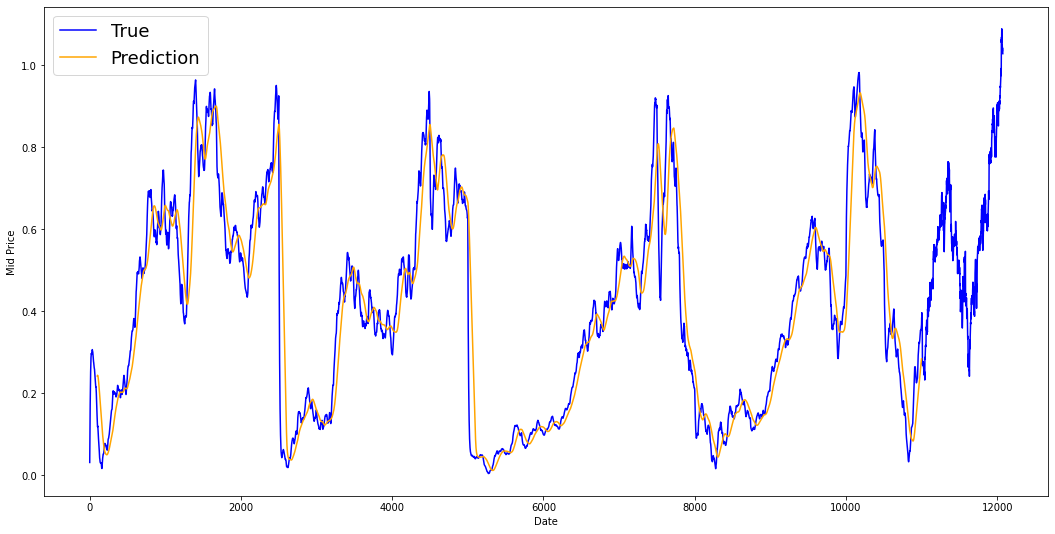

In [13]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Results for the averaging method show that, for very short predictions (i.e., one day ahead), it actually does very well.


## Exponential Moving Average

In [14]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


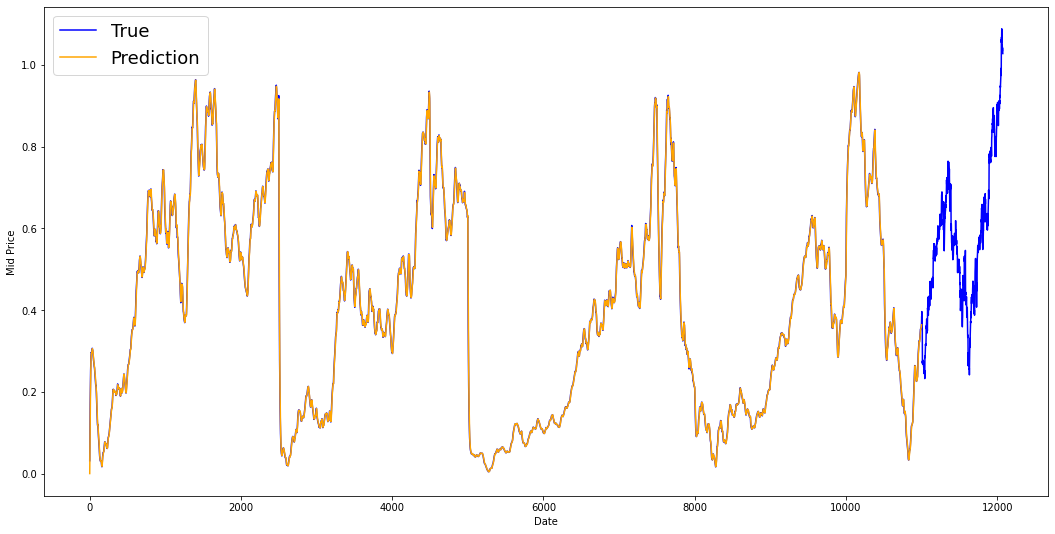

In [15]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

You may see that it is perfectly predicting the day-after prediction, as well as the very low MSE. 
BUT, this is just predicting the stock price for the next day, which may not be practically useful.

Thus, we turn to deep learning models. LSTMs, to be specific.

# Building the LSTM Model

## Data Generator and Augmentation

Before we start, we must first implement a *Data Generator* to train the model. We will also perform data augmentation to make our model more robust 

In [16]:
class DataGenerator(object):
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range (self._batch_size)]
    
    def next_batch(self):
        batch_data = np.zeros((self._batch_size), dtype=np.float32)
        batch_labels = np.zeros((self._batch_size), dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1 >= self._prices_length:
                self._cursor[b] = np.random.randint(0, (b+1)*self._segments)
            
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0,5)]
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels
    
    def unroll_batches(self):
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [17]:
dg = DataGenerator(train_data, 5, 5)
u_data, u_labels = dg.unroll_batches()

for i, (dat, lbl) in enumerate(zip(u_data, u_labels)):
    print('\n\nUnrolled index %d'%i)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03143791 0.6904868  0.82829314 0.32585657 0.11600105]

	Output: [0.132895   0.6890754  0.8329321  0.32857886 0.12106793]


Unrolled index 1
	Inputs:  [0.06067836 0.6890754  0.8325337  0.32857886 0.11785509]

	Output: [0.11098009 0.6836884  0.8325337  0.33421066 0.12158521]


Unrolled index 2
	Inputs:  [0.08698314 0.68685144 0.8329321  0.33078218 0.11946969]

	Output: [0.132895   0.6858036  0.83294916 0.33219692 0.11946969]


Unrolled index 3
	Inputs:  [0.11098009 0.6858036  0.83294916 0.33219692 0.12106793]

	Output: [0.11098009 0.6848606  0.83294916 0.33219692 0.12230608]


Unrolled index 4
	Inputs:  [0.132895   0.6848606  0.833369   0.33355275 0.12158521]

	Output: [0.17132245 0.6820074  0.833369   0.34456673 0.12192084]


Our hyperparameters are listed below.

In [18]:
import tensorflow as tf

INPUT_DIM = 1
NUM_UNROLLS = 50 #number of time steps to look into the future
BATCH_SIZE = 500 #number of samples in a batch
NUM_NODES = [200, 200, 150] #Number of Hidden nodes in each LSTM layer
N_LAYERS = len(NUM_NODES) #number of layers
EPOCHS = 30
DROPOUT_UNIT = 0.2
VALID_SUMMARY = 1 # Interval you make test predictions
N_PREDICT_ONCE = 50 # Number of steps you continously predict for

# if you run this multiple times, don't forget the line below.
tf.compat.v1.reset_default_graph()

In [19]:
tf.compat.v1.disable_eager_execution()

In [20]:
train_inputs, train_outputs = [], []

#unroll the input over time
for ui in range(NUM_UNROLLS):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[BATCH_SIZE,INPUT_DIM],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[BATCH_SIZE,1], name = 'train_outputs_%d'%ui))

In [21]:
LSTM_CELLS = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(
        num_units=NUM_NODES[li],
        state_is_tuple=True,
        initializer=tf.keras.initializers.GlorotNormal)
for li in range(N_LAYERS)]

DROP_LSTM_CELLS = [
    tf.compat.v1.nn.rnn_cell.DropoutWrapper(
        lstm, input_keep_prob=1.0, output_keep_prob=1.0-DROPOUT_UNIT, state_keep_prob=1.0-DROPOUT_UNIT)
    for lstm in LSTM_CELLS]

DROP_MULTI_CELLS = tf.keras.layers.StackedRNNCells(DROP_LSTM_CELLS)
MULTI_CELLS = tf.keras.layers.StackedRNNCells(LSTM_CELLS)

w = tf.compat.v1.get_variable('w', shape=[NUM_NODES[-1], 1], initializer=tf.keras.initializers.GlorotNormal)
b = tf.compat.v1.get_variable('b', initializer=tf.compat.v1.random_uniform([1], -0.1, 0.1))

C:\Users\ADRIC\AppData\Local\Temp\ipykernel_65232\2173716529.py:2: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  tf.compat.v1.nn.rnn_cell.LSTMCell(


In [22]:
c, h = [], []
initial_state = []
for li in range(N_LAYERS):
    c.append(tf.Variable(tf.zeros([BATCH_SIZE, NUM_NODES[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([BATCH_SIZE, NUM_NODES[li]]), trainable=False))
    initial_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c[li], h[li]))

all_inputs = tf.concat([tf.expand_dims(t, 0) for t in train_inputs], axis=0)

all_lstm_outputs, state = tf.compat.v1.nn.dynamic_rnn(
    DROP_MULTI_CELLS, all_inputs, initial_state = tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [BATCH_SIZE*NUM_UNROLLS, NUM_NODES[-1]])
all_outputs = tf.compat.v1.nn.xw_plus_b(all_lstm_outputs, w, b)
split_outputs = tf.split(all_outputs, NUM_UNROLLS, axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


c:\Users\ADRIC\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
c:\Users\ADRIC\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(


In [23]:
print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.compat.v1.assign(c[li], state[li][0]) for li in range(N_LAYERS)]+
                             [tf.compat.v1.assign(h[li], state[li][1]) for li in range(N_LAYERS)]):
  for ui in range(NUM_UNROLLS):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.compat.v1.assign(global_step,global_step + 1)
tf_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [24]:
print('Defining prediction related TF functions')

sample_inputs = tf.compat.v1.placeholder(tf.float32, shape=[1,INPUT_DIM])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(N_LAYERS):
  sample_c.append(tf.Variable(tf.zeros([1, NUM_NODES[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, NUM_NODES[li]]), trainable=False))
  initial_sample_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.compat.v1.group(*[tf.compat.v1.assign(sample_c[li],tf.zeros([1, NUM_NODES[li]])) for li in range(N_LAYERS)],
                               *[tf.compat.v1.assign(sample_h[li],tf.zeros([1, NUM_NODES[li]])) for li in range(N_LAYERS)])

sample_outputs, sample_state = tf.compat.v1.nn.dynamic_rnn(MULTI_CELLS, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.compat.v1.assign(sample_c[li],sample_state[li][0]) for li in range(N_LAYERS)]+
                              [tf.compat.v1.assign(sample_h[li],sample_state[li][1]) for li in range(N_LAYERS)]):  
  sample_prediction = tf.compat.v1.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [26]:
train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.compat.v1.InteractiveSession()

tf.compat.v1.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGenerator(train_data,BATCH_SIZE,NUM_UNROLLS)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(EPOCHS):       

    # ========================= Training =====================================
    for step in range(train_seq_length//BATCH_SIZE):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % VALID_SUMMARY == 0:

      average_loss = average_loss/(VALID_SUMMARY*(train_seq_length//BATCH_SIZE))

      # The average loss
      if (ep+1)%VALID_SUMMARY==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-VALID_SUMMARY==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-NUM_UNROLLS+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(N_PREDICT_ONCE):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-VALID_SUMMARY==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= N_PREDICT_ONCE
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-VALID_SUMMARY==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

c:\Users\ADRIC\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 2.246857


C:\Users\ADRIC\AppData\Local\Temp\ipykernel_65232\1173943720.py:89: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  our_predictions.append(np.asscalar(pred))


	Test MSE: 0.01552
	Finished Predictions
Average loss at step 2: 0.159905
	Test MSE: 0.00738
	Finished Predictions
Average loss at step 3: 0.082876
	Test MSE: 0.00442
	Finished Predictions
Average loss at step 4: 0.068348
	Test MSE: 0.00316
	Finished Predictions
Average loss at step 5: 0.057241
	Test MSE: 0.00298
	Finished Predictions
Average loss at step 6: 0.054956
	Test MSE: 0.00270
	Finished Predictions
Average loss at step 7: 0.050489
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 8: 0.046835
	Test MSE: 0.00296
	Finished Predictions
Average loss at step 9: 0.050669
	Test MSE: 0.00261
	Finished Predictions
Average loss at step 10: 0.045112
	Decreasing learning rate by 0.5
	Test MSE: 0.00265
	Finished Predictions
Average loss at step 11: 0.044192
	Test MSE: 0.00289
	Finished Predictions
Average loss at step 12: 0.043128
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 13: 0.037882
	Decreasing learning rate by 0.5
	Test MSE: 0.00243
	Finished Predictions
A

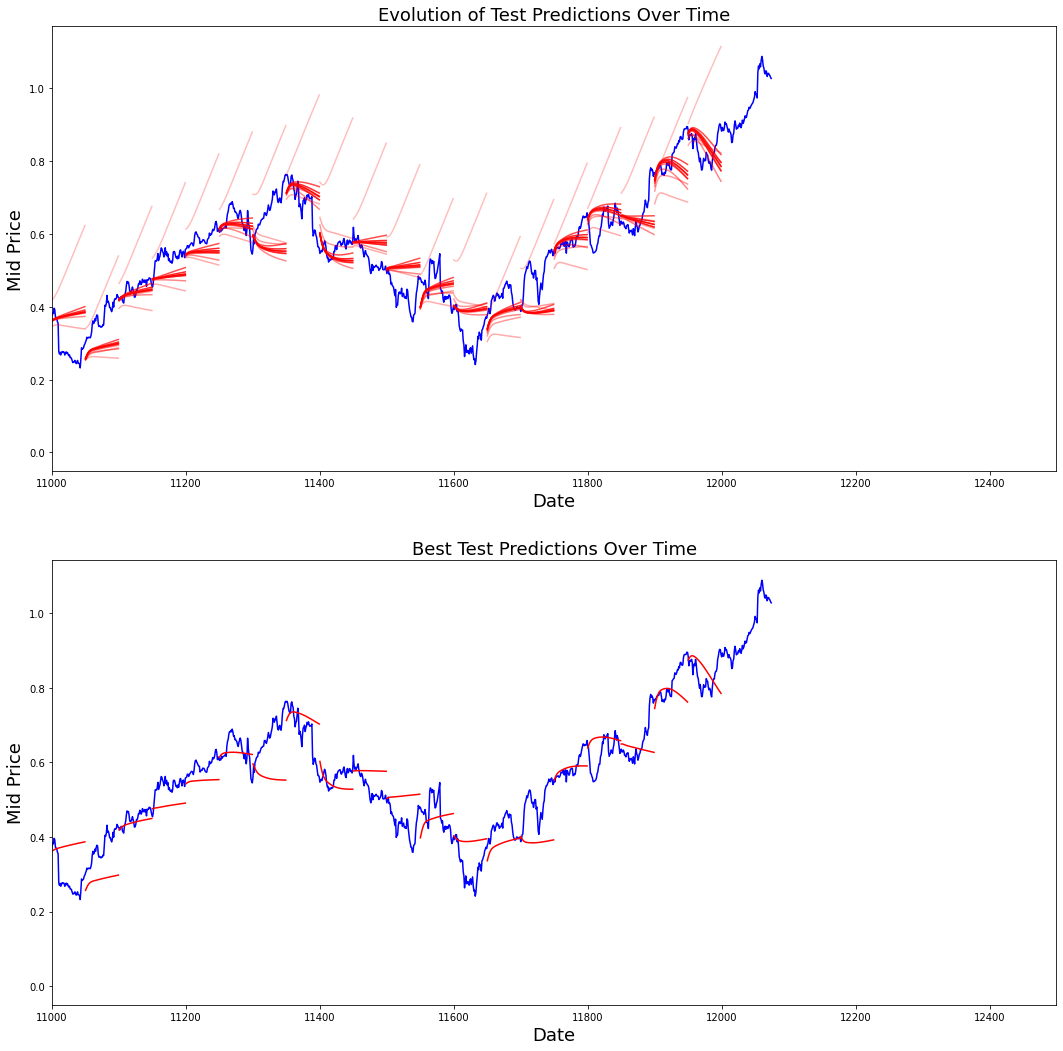

In [28]:
best_prediction_epoch = 15 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()